In [1]:
cat("Last updated:", date(), "(PT)")

Last updated: Mon Jun 29 18:21:55 2020 (PT)

In [2]:
# The R-package `renv` was used to create an R virtual environment.
# To install `renv`, do `install.packages('renv')`.
# To initialize an R environment, `renv::init()`.
# This will create a directory called `renv` in the current dir.

# See also:
# renv::init()
# renv::activate()
# renv::settings$snapshot.type('all')
# renv::status()
# renv::snapshot()
# renv::restore()

In [3]:
renv::activate("../../..")  # activate the project env.

In [4]:
library(nimble)
library(rjson)

nimble version 0.9.1 is loaded.
For more information on NIMBLE and a User Manual,
please visit http://R-nimble.org.


Attaching package: ‘nimble’


The following object is masked from ‘package:stats’:

    simulate




In [5]:
# NOTE: From NIMBLE docs: https://r-nimble.org/html_manual/cha-bnp.html
#
# Nimble doesn't allow dynamic allocation of new clusters. So, K is an upperbound
# for the number of clusters for computational and memory convenience. K should
# be much less than N.
model.code = nimbleCode({
    # Class Labels
    z[1:N] ~ dCRP(alpha, size=N)
    
    # DP concentration parameter
    alpha ~ dgamma(1, 100)
    
    for(k in 1:K) {
        mu[k] ~ dnorm(0, 3)
        sig2[k] ~ dinvgamma(2, 0.05)
    }
    
    for(i in 1:N) {
        y[i] ~ dnorm(mu[z[i]], var=sig2[z[i]])  
    }
})

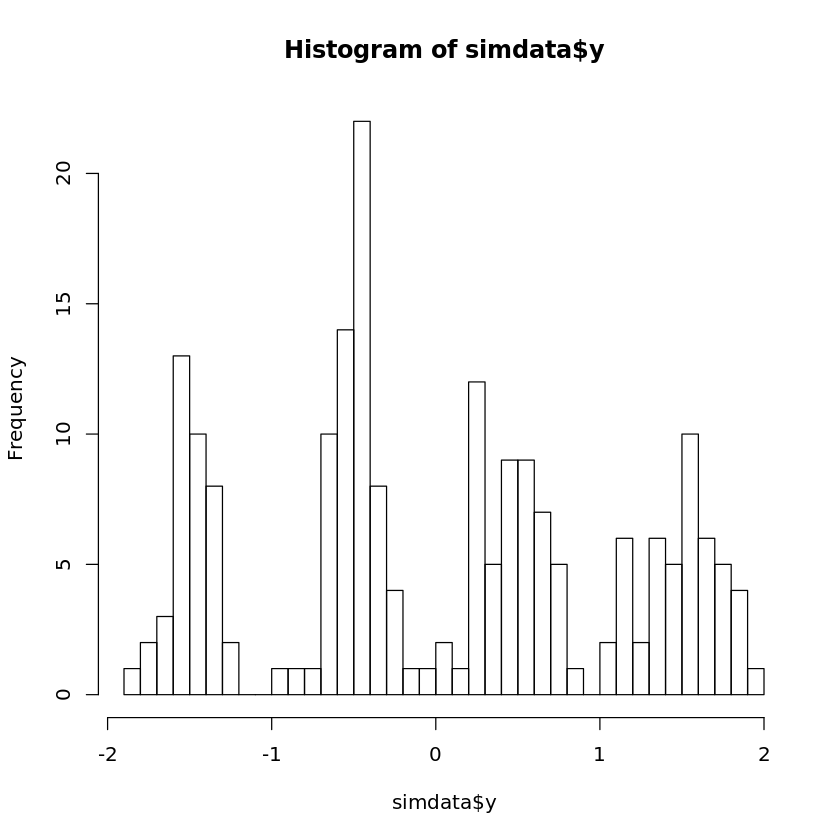

In [6]:
# Give the input file name to the function.
path_to_simdata = "../../data/sim-data/gmm-data-n200.json"
simdata = fromJSON(file=path_to_simdata)
hist(simdata$y, breaks=30)

In [7]:
set.seed(2)

data = list(y=simdata$y)
constants = list(N=length(data$y), K=10)
inits = list(mu=rnorm(constants$K, 0, 3),
             sig2=rep(0.01, constants$K),
             z=rep(1, constants$N),
             alpha=0.1)

In [8]:
# burn = 1000
# nsamples = 1000
# samples = nimbleMCMC(code=model.code, 
#                      constants=constants, 
#                      data=data, 
#                      inits=inits,
#                      monitors=c('mu', 'sig2', 'alpha', 'z'), setSeed=1,
#                      nburnin=burn, niter=burn + nsamples, progressBar=TRUE)

In [9]:
system.time({
    dp_crp_gmm <- nimbleModel(model.code, constants, data, inits)
    compiled_dp_crp_gmm <- compileNimble(dp_crp_gmm)
    mcmc <- buildMCMC(compiled_dp_crp_gmm, monitors=c('alpha', 'sig2', 'mu', 'z'))
    compiled_dp_crp_gmm <- compileNimble(mcmc)
})

defining model...

building model...

setting data and initial values...

running calculate on model (any error reports that follow may simply reflect missing values in model variables) ... 


checking model sizes and dimensions...


model building finished.

compiling... this may take a minute. Use 'showCompilerOutput = TRUE' to see C++ compilation details.

compilation finished.



===== Monitors =====
thin = 1: alpha, sig2, mu, z
===== Samplers =====
CRP_concentration sampler (1)
  - alpha
CRP_cluster_wrapper sampler (20)
  - sig2[]  (10 elements)
  - mu[]  (10 elements)
CRP sampler (1)
  - z[1:200] 


Warning message in samplerFunction(model = model, mvSaved = mvSaved, target = target, :
“sampler_CRP: The number of cluster parameters is less than the number of potential clusters. The MCMC is not strictly valid if it ever proposes more components than cluster parameters exist; NIMBLE will warn you if this occurs.
”
compiling... this may take a minute. Use 'showCompilerOutput = TRUE' to see C++ compilation details.

compilation finished.



   user  system elapsed 
 21.501   0.728  22.247 

In [10]:
system.time({
    samples <- runMCMC(compiled_dp_crp_gmm, nburnin=1000, niter=2000, setSeed=1)
})

running chain 1...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


   user  system elapsed 
  1.098   0.000   1.097 

In [11]:
colnames(samples)
dim(samples)

[1] "alpha"    "mu[1]"    "mu[2]"    "mu[3]"    "mu[4]"    "mu[5]"   
  [7] "mu[6]"    "mu[7]"    "mu[8]"    "mu[9]"    "mu[10]"   "sig2[1]" 
 [13] "sig2[2]"  "sig2[3]"  "sig2[4]"  "sig2[5]"  "sig2[6]"  "sig2[7]" 
 [19] "sig2[8]"  "sig2[9]"  "sig2[10]" "z[1]"     "z[2]"     "z[3]"    
 [25] "z[4]"     "z[5]"     "z[6]"     "z[7]"     "z[8]"     "z[9]"    
 [31] "z[10]"    "z[11]"    "z[12]"    "z[13]"    "z[14]"    "z[15]"   
 [37] "z[16]"    "z[17]"    "z[18]"    "z[19]"    "z[20]"    "z[21]"   
 [43] "z[22]"    "z[23]"    "z[24]"    "z[25]"    "z[26]"    "z[27]"   
 [49] "z[28]"    "z[29]"    "z[30]"    "z[31]"    "z[32]"    "z[33]"   
 [55] "z[34]"    "z[35]"    "z[36]"    "z[37]"    "z[38]"    "z[39]"   
 [61] "z[40]"    "z[41]"    "z[42]"    "z[43]"    "z[44]"    "z[45]"   
 [67] "z[46]"    "z[47]"    "z[48]"    "z[49]"    "z[50]"    "z[51]"   
 [73] "z[52]"    "z[53]"    "z[54]"    "z[55]"    "z[56]"    "z[57]"   
 [79] "z[58]"    "z[59]"    "z[60]"    "z[61]"    "z[62]"    "z[63]"   
 [85] "z[64]"    "z[65]"    "z[66]"    "z[67]"    "z[68]"    "z[69]"   
 [91] "z[70]"    "z[71]"    "z[72]"    "z[73]"    "z[74]"    "z[75]"   
 [97] "z[76]"    "z[77]"    "z[78]"    "z[79]"    "z[80]"    "z[81]"   
[103] "z[82]"    "z[83]"    "z[84]"    "z[85]"    "z[86]"    "z[87]"   
[109] "z[88]"    "z[89]"    "z[90]"    "z[91]"    "z[92]"    "z[93]"   
[115] "z[94]"    "z[95]"    "z[96]"    "z[97]"    "z[98]"    "z[99]"   
[121] "z[100]"   "z[101]"   "z[102]"   "z[103]"   "z[104]"   "z[105]"  
[127] "z[106]"   "z[107]"   "z[108]"   "z[109]"   "z[110]"   "z[111]"  
[133] "z[112]"   "z[113]"   "z[114]"   "z[115]"   "z[116]"   "z[117]"  
[139] "z[118]"   "z[119]"   "z[120]"   "z[121]"   "z[122]"   "z[123]"  
[145] "z[124]"   "z[125]"   "z[126]"   "z[127]"   "z[128]"   "z[129]"  
[151] "z[130]"   "z[131]"   "z[132]"   "z[133]"   "z[134]"   "z[135]"  
[157] "z[136]"   "z[137]"   "z[138]"   "z[139]"   "z[140]"   "z[141]"  
[163] "z[142]"   "z[143]"   "z[144]"   "z[145]"   "z[146]"   "z[147]"  
[169] "z[148]"   "z[149]"   "z[150]"   "z[151]"   "z[152]"   "z[153]"  
[175] "z[154]"   "z[155]"   "z[156]"   "z[157]"   "z[158]"   "z[159]"  
[181] "z[160]"   "z[161]"   "z[162]"   "z[163]"   "z[164]"   "z[165]"  
[187] "z[166]"   "z[167]"   "z[168]"   "z[169]"   "z[170]"   "z[171]"  
[193] "z[172]"   "z[173]"   "z[174]"   "z[175]"   "z[176]"   "z[177]"  
[199] "z[178]"   "z[179]"   "z[180]"   "z[181]"   "z[182]"   "z[183]"  
[205] "z[184]"   "z[185]"   "z[186]"   "z[187]"   "z[188]"   "z[189]"  
[211] "z[190]"   "z[191]"   "z[192]"   "z[193]"   "z[194]"   "z[195]"  
[217] "z[196]"   "z[197]"   "z[198]"   "z[199]"   "z[200]"

[1] 1000  221

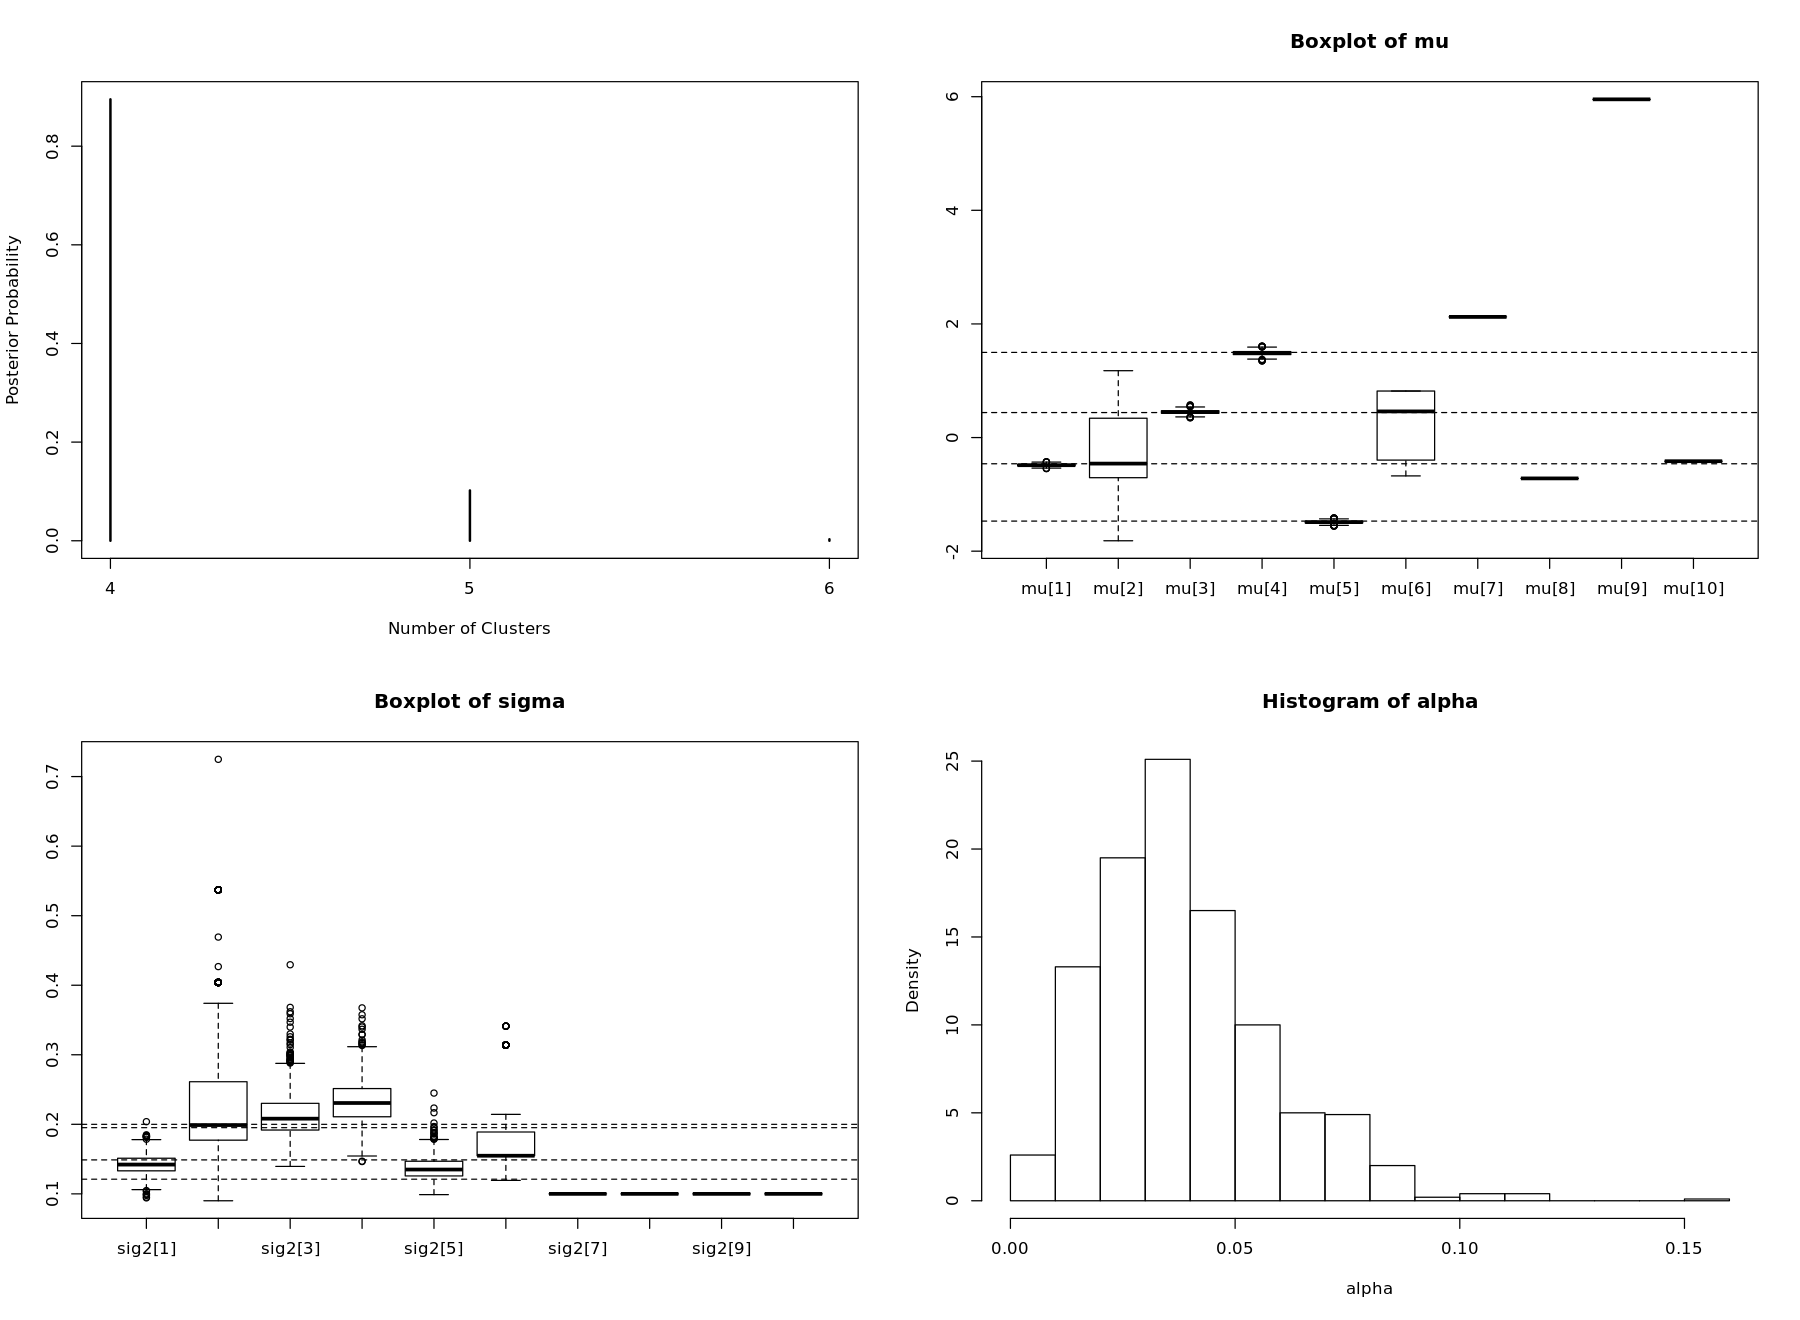

In [12]:
N = constants$N
mu = samples[, 2:11]
sig2 = samples[, 12:21]
alpha = samples[, 'alpha']
z = samples[, 22:(22+N-1)]

num_clus = apply(z, 1, function(row) length(unique(row)))
                 
options(repr.plot.width=15, repr.plot.height=11)
par(mfrow=c(2,2))
plot(table(num_clus)/NROW(num_clus), xlab="Number of Clusters", ylab="Posterior Probability")

# NOTE: Some of the components do not get updated under the CRP
# representation because they never get used.                 
boxplot(mu, main="Boxplot of mu")
abline(h=simdata$mu, lty=2)

boxplot(sqrt(sig2), main="Boxplot of sigma")
abline(h=simdata$sig, lty=2)

hist(alpha, prob=TRUE)